##### What is this notebook about?
- This notebook shows how to implement key components of following LLM models from scratch in Pytorch to understand the concepts
    - GPT-2
    - LLama-2
    - Llama-3, 3.1, 3.2
- Some key components are:
    - Tokenization 
        - BPE: GPT-2, Llama-3* models
        - SentencePiece: Llama-2 model
    - Token Embeddings layer
        - Weight tying between input & output embedding layers: GPT-2, Llama-3.2
    - Transformer block
        - Attention mechanism
            - Multi-head attention (MHA) + Causal attention (since Decoder only model)
                - Additional optimizations?
                    - None: GPT-2
                    - Group query attention (GQA): Llama-3
            - Positional embeddings
                - Absolute, learnable: GPT-2
                - Rotary (RoPE): Llama-2,3* models
                    - RoPE rescaling factor / inverse frequency changes: Llama-3.1, 3.2
        - Feedforward network (FFN)
            - Activation function 
                - GELU: GPT-2
                - SiLU/SwiGLU: Llama-2,3* models
        - Activation Normalization 
            - LayerNorm: GPT-2
                - Pre-LayerNorm: LayerNorm, MHA, Dropout --> LayerNorm, FFN, Dropout
                - Post-LayerNorm: MHA, FFN, LayerNorm, Dropout
            - RMSNorm: Llama-2,3* models
        - Skip/Shortcut connections
        - Dropout
    - Final output layer
        - Activation normalization
            - LayerNorm: GPT-2
        - Token Embeddings layer

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(2024)



### LayerNorm (vs) RMSNorm
- Why LayerNorm instead of BatchNorm: 
    - Make it robust to training batch size or seq length changes, and also easier to parallelize (no sync required across devices)
- Why RMSNorm
    - Only 1 learnable parameter => faster

In [2]:
# 2 parameters: scale, shift
class LayerNorm(nn.Module):
    def __init__(self, dim, eps):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))
        self.shift = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # unbiased False => No Bessel's correction => variance formula has divide by n (not n-1)
        norm = (x - mean) / torch.sqrt(var + self.eps)
        ln = self.scale*norm + self.shift
        return ln

# 1 parameter: scale (no mean shift)
class RMSNorm(nn.Module):
    def __init__(self, dim, eps):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))
        
    def forward(self, x):
        mean = x.pow(2).mean(dim=-1, keepdim=True)
        norm = x * torch.rsqrt(mean + self.eps)
        rn = self.scale*norm
        return rn


In [3]:
x = torch.randn(2, 3, 4) # bs, seq_len, dim
print(x)

# LayerNorm
lnorm = LayerNorm(dim=x.shape[-1], eps=1e-5)
lnorm_pt = nn.LayerNorm(x.shape[-1], eps=1e-5)
x_lnorm = lnorm(x)
x_lnorm_pt = lnorm_pt(x)
print("\nLayerNorm")
print(x_lnorm)
eq = torch.allclose(x_lnorm, x_lnorm_pt)
print(eq)

# RMSNorm
rms_norm = RMSNorm(dim=x.shape[-1], eps=1e-5)
rms_norm_pt = nn.RMSNorm(x.shape[-1], eps=1e-5)
x_rms_norm = rms_norm(x)
x_rms_norm_pt = rms_norm_pt(x)
print("\nRMSNorm")
print(x_rms_norm)
eq = torch.allclose(x_rms_norm, x_rms_norm_pt)
print(eq)

tensor([[[-1.2262, -0.0093,  1.5420, -0.4657],
         [ 0.2795, -0.2610,  0.6230, -1.1561],
         [ 0.7131, -0.3869, -0.2535, -1.6675]],

        [[-0.3712,  0.1377, -0.5199, -0.3497],
         [-0.0776, -1.1175, -0.6481,  0.6530],
         [-0.1596,  0.3569,  0.6595, -0.1452]]])

LayerNorm
tensor([[[-1.1730,  0.0302,  1.5639, -0.4210],
         [ 0.6076, -0.1970,  1.1190, -1.5296],
         [ 1.3132,  0.0139,  0.1715, -1.4986]],

        [[-0.3854,  1.6701, -0.9862, -0.2985],
         [ 0.3328, -1.2407, -0.5304,  1.4383],
         [-0.9719,  0.5154,  1.3870, -0.9304]]], grad_fn=<AddBackward0>)
True

RMSNorm
tensor([[[-1.2114, -0.0092,  1.5234, -0.4601],
         [ 0.4087, -0.3816,  0.9109, -1.6904],
         [ 0.7620, -0.4135, -0.2709, -1.7819]],

        [[-1.0016,  0.3717, -1.4029, -0.9435],
         [-0.1071, -1.5418, -0.8942,  0.9009],
         [-0.4090,  0.9147,  1.6904, -0.3720]]], grad_fn=<MulBackward0>)
True


### GELU (vs) SiLU
- Rectified Linear Unit (ReLU): 
    - Used in vanilla transformers. Dying gradients for negative activations. 
- Gaussian Error Linear Unit (GELU): 
    - Used in GPT-2. Smoother
- Sigmoid weighted Linear Unit (SiLU): 
    - More smooth. Used inside FFN of Llama-2,3* models

In [4]:
class Sigmoid(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        return 1./(1 + torch.exp(-x))

class Tanh(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        return torch.tanh(x)
    
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.maximum(x, torch.tensor(0.0))
    
class LeakyReLU(nn.Module):
    def __init__(self, negative_slope=1e-2):
        super().__init__()
        self.negative_slope = negative_slope

    def forward(self, x):
        return torch.where(x > 0, x, self.negative_slope * x)

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # approximation of x.cdf(N(x))
        return 0.5*x*(
                    1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3)))
                    )

class SiLU(nn.Module):
    def __init__(self,):
        super().__init__()
        
    def forward(self, x):
        return x * torch.sigmoid(x)

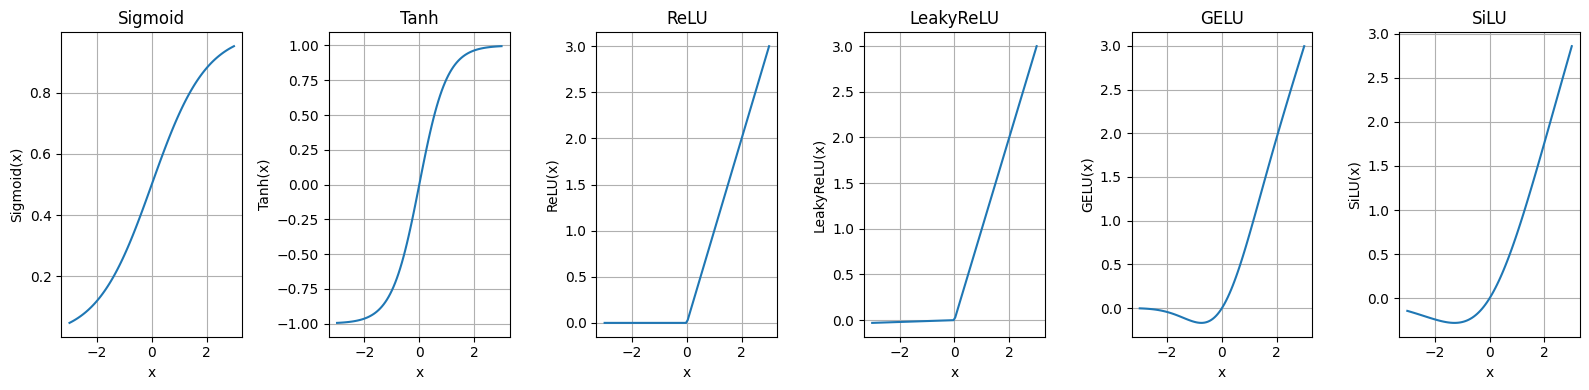

In [5]:
sigmoid, tanh, relu, lrelu, gelu, silu = Sigmoid(), Tanh(), ReLU(), LeakyReLU(), GELU(), SiLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_sigmoid, y_tanh, y_relu, y_lrelu, y_gelu, y_silu = sigmoid(x), tanh(x), relu(x), lrelu(x), gelu(x), silu(x)

plt.figure(figsize=(16, 4))
for i, (y, label) in enumerate(zip([y_sigmoid, y_tanh, y_relu, y_lrelu, y_gelu, y_silu], ["Sigmoid", "Tanh", "ReLU", "LeakyReLU", "GELU", "SiLU"]), 1):
    plt.subplot(1, 6, i)
    plt.plot(x, y)
    plt.title(f"{label}")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
if False:
    
    x = torch.randn(2, 3, 4) # bs, seq_len, dim
    print(f"{x}\n")

    x_act_tuples = [("Sigmoid", sigmoid(x), nn.functional.sigmoid(x)), 
                    ("Relu", relu(x),  nn.functional.relu(x)), 
                    ("LeakyRelu", lrelu(x), nn.functional.leaky_relu(x)),
                    ("Gelu", gelu(x), nn.functional.gelu(x)),
                    ("Silu", silu(x), nn.functional.silu(x))]

    for activation_name, x_c, x_pt in x_act_tuples:
        print(f"{activation_name}")
        print(x_c)
        eq = torch.allclose(x_c, x_pt)
        print(f"{eq}\n")

### Feedforward layer: Regular FFN (vs) SwiGLU FFN
- Regular FFN:
    - Uses GELU actvn
    - Used in Vanilla transformer, GPT-2
- SwiGLU FFN: 
    - Applies Gated Linear Unit (GLU), i.e gate the input
    - Uses SiLU actvn.
    - Used in Llama-2,3* models

In [7]:
# Regular FFN with GELU actvn
class FFN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        hidden_dim = 4*dim
        self.layers = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.layers(x)

# SwiGLU FFN with SiLU actvn
class FFNSwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, dtype=None, bias=False):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim, dtype=dtype, bias=bias)
        self.fc2 = nn.Linear(dim, hidden_dim, dtype=dtype, bias=bias)
        self.fc3 = nn.Linear(hidden_dim, dim, dtype=dtype, bias=bias)
        self.silu = SiLU()

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = self.silu(x_fc1) * x_fc2
        return self.fc3(x)

In [8]:
x = torch.randn(2, 3, 4) # bs, seq_len, dim
print(x)

# Regular FFN
ffn = FFN(dim=x.shape[-1])
x_op = ffn(x)
print("\nReg FFN")
print(x_op)

# SwiGLU FFN
ffn_swiglu = FFNSwiGLU(dim=x.shape[-1], hidden_dim=x.shape[-1]*4)
x_op = ffn_swiglu(x)
print("\nSwiGLU FFN")
print(x_op)

tensor([[[ 0.0306, -0.5932, -0.5154,  0.5214],
         [-0.3626, -1.0657, -0.1616, -2.6492],
         [ 0.3171, -1.8716, -0.0894,  0.7485]],

        [[ 0.6137, -0.4419,  0.0984, -0.1520],
         [-0.5458,  0.9425,  0.3299,  1.5264],
         [-0.1864,  0.9193, -0.3248,  1.3998]]])

Reg FFN
tensor([[[-0.0851,  0.1634,  0.2544,  0.0912],
         [-0.0408,  0.8007, -0.0245,  0.1304],
         [-0.3139,  0.1388,  0.3955,  0.0671]],

        [[-0.1838,  0.1320,  0.1881,  0.1824],
         [-0.0194,  0.0916, -0.2381,  0.1762],
         [-0.0885,  0.1518, -0.1587,  0.1018]]], grad_fn=<ViewBackward0>)

SwiGLU FFN
tensor([[[ 0.0034,  0.0133,  0.0156,  0.0053],
         [-0.3016, -0.1899,  0.0846, -0.1377],
         [ 0.0138,  0.1793,  0.0284,  0.0598]],

        [[-0.0026,  0.0154,  0.0082,  0.0215],
         [-0.0113,  0.0069,  0.0409, -0.0247],
         [-0.0609, -0.0304,  0.0311, -0.0298]]], grad_fn=<UnsafeViewBackward0>)


### Positional embeddings: Absolute (vs) RoPE

In [9]:
class x(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        pass

class y(nn.Module):
    def __init__(self,):
        super().__init__()
        
    def forward(self, x):
        pass

### MHA: Regular (vs) GQA

#### Regular MHA
- For given input embedding, create q, k, v embeddings to be same size as input embedding
- Split q, k, v embeddings into num_heads 
- Perform attention on each head
- Compute context for each head
- Reshape & Concatenate context results from all heads
- Also, apply linear layer (proj) on context 

#### GQA
- Multiple query heads share the same key, value. So, we can use reduced number of parameters for keys, values
    - Lets say, 4 query heads share same key, value
- For given input embedding (lets say dim=4096), 
    - create q embedding to be same size as input embedding
    - create k, v embeddings to be 1/4 size as input embedding
- Split q embeddings into num_heads groups (lets say num_heads=32)
- Split k, v embeddings into num_heads//4 groups. (8 groups)
    - Replicate them 4 times so that they appear as num_heads. (32 heads)
- Perform attention on each head
- Compute context for each head
- Reshape & Concatenate context results from all heads
- Also, apply linear layer (proj) on context 
> - Example:  
> dim = 4096  
> num_heads = 32   
> num_kv_groups = 8   
> head_dim = dim // num_heads = 128 
>> - Share k, v across q  
> q_group_size = num_heads // num_kv_groups = 32 // 8 = 4   
> => 4 query heads share 1 k,v  
> Wq     : dim -> num_heads     * head_dim = 4096 (32 * 128)  
> Wk, Wv : dim -> num_kv_groups * head_dim = 1024 (8 * 128)  
> => Reduced number of params on Wk, Wv  
> q  = [4096] = [128, 128, ...      ]  (32 heads)  
> k  = [1024] = [128, 128, ...] (8 parts)  
> v  = [1024] = [128, 128, ...] (8 parts)  
>> - Repeat each k, v params 4x for matrix mult  
> k' = [4096] = [128, 128, ...      ]  (32 heads)  
> v '= [4096] = [128, 128, ...      ]  (32 heads)  
>> - Calculate attn
> att_scores = [32 heads, seq_len, seq_len]
> ctx = [32 heads, seq_len, 128]
>> - Reshape & Concatenate  
> => ctx = [seq_len, 32 * 128]  = [seq_len, 4096]


In [19]:
class MHA2(nn.Module):
    def __init__(self, din, dim, ctx_len, dropout, num_heads, bias=False, dtype=None):
        super().__init__()

        assert dim % num_heads == 0, "Given dim should be multiple of num_heads"
        self.head_dim = dim // num_heads
        self.num_heads, self.din, self.dim = num_heads, din, dim
        
        self.wq = nn.Linear(din, dim, bias=bias, dtype=dtype)
        self.wk = nn.Linear(din, dim, bias=bias, dtype=dtype) 
        self.wv = nn.Linear(din, dim, bias=bias, dtype=dtype)  
        
        att_mask = torch.triu(torch.ones(ctx_len, ctx_len), diagonal=1)
        self.register_buffer('att_mask', att_mask)

        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim, bias=bias, dtype=dtype) # bias can be True here, even if qkv bias can be False

    def forward(self, x):
        bs, seq_len, din = x.shape
        
        q, k, v = self.wq(x), self.wk(x), self.wv(x)  # (bs, seq_len, dim)

        # Reshape to (bs, seq_len, num_heads, head_dim)
        q = q.view(bs, seq_len, self.num_heads, self.head_dim)
        k = k.view(bs, seq_len, self.num_heads, self.head_dim) 
        v = v.view(bs, seq_len, self.num_heads, self.head_dim) 

        # Reshape to calculate attn in parallel for all heads
        q = q.transpose(1, 2) # (bs, num_heads, seq_len, head_dim)
        k = k.transpose(1, 2) # (bs, num_heads, seq_len, head_dim)
        v = v.transpose(1, 2) # (bs, num_heads, seq_len, head_dim)
        
        # att matrix mult along seq_len, head_dim. 
        att = q @ k.transpose(2, 3) # (bs, num_heads, seq_len, seq_len)
        
        # causal attn + dropout 
        att_mask = self.att_mask.bool()[:seq_len, :seq_len] # Select mask for seq_len & convert to bool
        att.masked_fill_(att_mask, -torch.inf)      
        att = torch.softmax(att / k.shape[-1]**0.5, dim=-1)
        att = self.dropout(att)
        
        # Calc context & reshape from (bs, num_heads, seq_len, head_dim) & then to (bs, seq_len, num_heads, head_dim)
        ctx = (att @ v).transpose(1, 2)
        
        # Concatenate heads to get (bs, seq_len, dim) & make it contiguous in memory
        ctx = ctx.contiguous().view(bs, seq_len, self.dim)
        ctx = self.proj(ctx)

        return ctx

x = torch.randn(3, 4)
batch_x = torch.stack((x, x), dim=0) # Create a batch of input
din = batch_x.shape[2] # Input dim
ctx_len = 10 # Max ctx length supported
dim = 16 # dim of att layer embeddings
num_heads = 8
mha_layer = MHA2(din, dim, ctx_len, 0.1, num_heads)
ctx = mha_layer(batch_x) 

total_params = sum(p.numel() for p in mha_layer.parameters())
print(f"Number of parameters: {total_params:,}")
print(batch_x.shape)
print(ctx.shape, ctx)  # bs, seqlen, dim

Number of parameters: 448
torch.Size([2, 3, 4])
torch.Size([2, 3, 16]) tensor([[[ 0.2563, -0.1185,  0.0070, -0.0433, -0.1105, -0.0448, -0.1693,
          -0.1168,  0.2391, -0.0996, -0.0288,  0.0803, -0.1263,  0.1820,
           0.0670,  0.1743],
         [-0.2857,  0.1650, -0.2904,  0.2810,  0.4160,  0.0966,  0.2052,
          -0.6421,  0.1965,  0.0583,  0.1293,  0.3747, -0.4769,  0.5608,
          -0.2250,  0.1889],
         [-0.1320,  0.2058, -0.1630,  0.1820,  0.2972, -0.0687,  0.1669,
          -0.2793,  0.1095, -0.0939,  0.1820, -0.0179, -0.3088,  0.2962,
          -0.1833, -0.0989]],

        [[ 0.0316, -0.1082, -0.1250, -0.0224, -0.0342, -0.1109, -0.1448,
          -0.0425,  0.3179, -0.2385, -0.1627,  0.0687,  0.0140,  0.1354,
          -0.0188,  0.3842],
         [-0.4589,  0.0525, -0.1949,  0.0547,  0.4999,  0.1999,  0.2046,
          -0.4653,  0.0918, -0.1014,  0.1131,  0.2016, -0.6958,  0.4900,
          -0.1631,  0.0804],
         [-0.0831,  0.2025, -0.1822,  0.2321,  0.242

In [17]:
class GQA(nn.Module):

    def __init__(self, din, dim, ctx_len, dropout, num_heads, num_kv_groups, bias=False, dtype=None):
        super().__init__()

        assert dim % num_heads == 0, "Given dim should be multiple of num_heads"
        self.head_dim = dim // num_heads
        self.num_heads, self.din, self.dim = num_heads, din, dim

        assert num_heads % num_kv_groups == 0, "Given num_heads should be multiple of num_kv_groups"
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups  # Number of query heads per k, v

        self.wq = nn.Linear(din, dim, bias=bias, dtype=dtype)
        self.wk = nn.Linear(din, num_kv_groups * self.head_dim, bias=bias, dtype=dtype)
        self.wv = nn.Linear(din, num_kv_groups * self.head_dim, bias=bias, dtype=dtype)

        att_mask = torch.triu(torch.ones(ctx_len, ctx_len), diagonal=1)
        self.register_buffer('att_mask', att_mask)

        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim, bias=bias, dtype=dtype)

    def forward(self, x):
        bs, seq_len, din = x.shape
        
        q    = self.wq(x)               # (bs, seq_len, dim=num_heads*head_dim)
        k, v = self.wk(x), self.wv(x)   # (bs, seq_len, num_kv_groups*head_dim)

        # Reshape to (bs, seq_len, num_heads, head_dim)
        q = q.view(bs, seq_len, self.num_heads, self.head_dim)
        k = k.view(bs, seq_len, self.num_kv_groups, self.head_dim) 
        v = v.view(bs, seq_len, self.num_kv_groups, self.head_dim) 

        # Reshape to calculate attn in parallel for all heads
        q = q.transpose(1, 2) # (bs, num_heads, seq_len, head_dim)
        k = k.transpose(1, 2) # (bs, num_kv_groups, seq_len, head_dim)
        v = v.transpose(1, 2) # (bs, num_kv_groups, seq_len, head_dim)

        # Replicate k, v to match num_heads for q.
        # E.g. groupsize = 4. [k1, k2] -> [k1, k1, k1, k1, k2, k2, k2, k2]
        k = k.repeat_interleave(self.group_size, dim=1)  # (bs, num_heads, seq_len, head_dim)
        v = v.repeat_interleave(self.group_size, dim=1)  # (bs, num_heads, seq_len, head_dim)

        # att matrix mult along seq_len, head_dim. 
        att = q @ k.transpose(2, 3) # (bs, num_heads, seq_len, seq_len)
        
        # causal attn + dropout 
        att_mask = self.att_mask.bool()[:seq_len, :seq_len] # Select mask for seq_len & convert to bool
        att.masked_fill_(att_mask, -torch.inf)      
        att = torch.softmax(att / k.shape[-1]**0.5, dim=-1)
        att = self.dropout(att)
        
        # Calc context & reshape from (bs, num_heads, seq_len, head_dim) & then to (bs, seq_len, num_heads, head_dim)
        ctx = (att @ v).transpose(1, 2)
        
        # Concatenate heads to get (bs, seq_len, dim) & make it contiguous in memory
        #ctx = ctx.contiguous().view(bs, seq_len, self.dim)
        ctx = ctx.reshape(bs, seq_len, self.dim)
        ctx = self.proj(ctx)

        return ctx

x = torch.randn(3, 4)
batch_x = torch.stack((x, x), dim=0) # Create a batch of input
din = batch_x.shape[2] # Input dim
ctx_len = 10 # Max ctx length supported
dim = 16 # dim of att layer embeddings
num_heads = 8
num_kv_groups = 2 # i.e. 4 q heads share 1 k,v 
gqa_layer = GQA(din, dim, ctx_len, 0.1, num_heads, num_kv_groups)
ctx = gqa_layer(batch_x) 

total_params = sum(p.numel() for p in gqa_layer.parameters())
print(f"Number of parameters: {total_params:,}")
print(batch_x.shape)
print(ctx.shape, ctx)  # bs, seqlen, dim


Number of parameters: 352
torch.Size([2, 3, 4])
torch.Size([2, 3, 16]) tensor([[[ 1.5291e-01, -4.8844e-01, -6.5003e-02, -2.8238e-01,  7.3604e-02,
          -2.8628e-01,  2.9970e-01,  3.8079e-01, -1.1687e-01,  6.6611e-02,
           3.8450e-01,  1.2225e-01, -1.6228e-01, -6.2595e-02,  4.5064e-01,
          -1.6400e-01],
         [ 2.0337e-01, -3.2627e-01, -1.1239e-01, -1.1262e-01, -4.2313e-02,
          -1.5998e-01,  1.1199e-01,  2.9638e-01,  1.9492e-02,  5.6603e-02,
           3.6339e-02,  2.2948e-01, -2.1085e-01, -6.3770e-02,  7.6322e-02,
           5.9290e-02],
         [ 3.9667e-02, -1.4706e-02, -1.2167e-02,  5.9012e-03,  3.3273e-02,
          -5.9876e-02,  3.0878e-02, -2.3503e-02, -3.2827e-03,  2.9479e-04,
          -2.8955e-02,  2.0259e-02, -6.8267e-02,  1.9145e-02, -3.9347e-02,
           9.6402e-02]],

        [[ 2.3235e-01, -2.3399e-01, -1.1558e-01, -2.2501e-01,  1.0618e-01,
          -9.0833e-02,  1.7965e-01,  5.5679e-02, -9.3582e-02, -1.0986e-01,
           2.5765e-01,  3.8713

### Rope + GQA

### Tokenization 

In [ ]:

class x(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        pass

class y(nn.Module):
    def __init__(self,):
        super().__init__()
        
    def forward(self, x):
        pass